# TimeGrad vs Conditional TimeGrad Comparison

This notebook trains a lightweight vanilla TimeGrad model and a conditioning-aware TimeGrad variant on the same data, then visualizes their forecasts side by side.

## Setup
The imports assume this notebook lives in `notebooks/` under the project root.

In [1]:
import math
import os
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader

try:
    project_root = Path(__file__).resolve().parents[1]
except NameError:
    project_root = Path(os.getcwd()).resolve().parent

if str(project_root) not in os.sys.path:
    os.sys.path.insert(0, str(project_root))

from src.data_loader import TimeGradDataModule
from src.models.timegrad_core.timegrad_base import TimeGradBase
from src.predictor import ConditionalTimeGradPredictionNetwork
from src.training import ConditionalTimeGradTrainingNetwork

plt.style.use('seaborn-v0_8-darkgrid')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## Load & preprocess data
This matches the preprocessing flow used in the conditional demo notebook.

In [2]:
data_base = project_root / 'data'
raw_base = data_base / 'raw'

raw_paths = {
    'target': raw_base / 'target.parquet',
    'market': raw_base / 'market.parquet',
    'daily_macro': raw_base / 'daily_macro.parquet',
    'monthly_macro': raw_base / 'monthly_macro.parquet',
    'quarterly_macro': raw_base / 'quarterly_macro.parquet',
}
data_dict = {name: pd.read_parquet(path) for name, path in raw_paths.items()}
print({k: v.shape for k, v in data_dict.items()})

context_length = 64
prediction_length = 24
batch_size = 4

dm = TimeGradDataModule(
    data_dict=data_dict,
    seq_len=context_length,
    forecast_horizon=prediction_length,
    batch_size=batch_size,
    device=str(device),
)
dm.preprocess_and_split()
dm.build_datasets()

feature_cols = dm.get_feature_columns_by_type()
feature_cols['cond_dynamic'] = feature_cols['daily'] + feature_cols['monthly']
feature_cols['cond_static'] = feature_cols['regime']

print('Feature columns by type:')
for k, v in feature_cols.items():
    print(f"  {k}: {len(v)} cols")


{'target': (7052, 6), 'market': (7052, 6), 'daily_macro': (7305, 3), 'monthly_macro': (336, 5), 'quarterly_macro': (112, 6)}
🔧 [Init] Aligning and preparing macroeconomic data...
align_and_handle_missing_values: daily_df columns before processing: ['Date', 'yield_curve', 'vix']
align_and_handle_missing_values: daily_aligned columns after processing: ['yield_curve_daily', 'vix_daily']
✅ [Init] Macro data alignment complete.

build_raw_blocks: daily_macro_indexed columns before calling process_daily_macro_raw: ['yield_curve_daily', 'vix_daily']
🔄 [build_raw_blocks] Processing raw data blocks...
✅ Target wavelet denoising complete.
✅ Market log-returns computed.
✅ Daily macro block processed.
✅ Monthly macro transformations complete.
✅ Quarterly macro transformations complete.
🏗️ [build_raw_blocks] All raw data blocks prepared.

🔄 [preprocess_raw_merge] Merging all blocks into unified DataFrame...
✅ All blocks merged successfully.
🔄 Adding calendar and regime features...
✅ Calendar featur

## Minimal vanilla TimeGrad wrapper
The helper below mirrors the conditional wrapper's normalization but omits conditioning. It allows quick training and sampling for the baseline model.

In [3]:
class VanillaTimeGradWrapper(nn.Module):
    def __init__(self, target_dim: int, prediction_length: int, scale_eps: float = 1e-5):
        super().__init__()
        self.prediction_length = prediction_length
        self.scale_eps = scale_eps
        self.model = TimeGradBase(target_dim=target_dim, prediction_length=prediction_length)

    def _normalize(self, x_hist: torch.Tensor, x_future: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        combined = torch.cat([x_hist, x_future], dim=1)
        loc = combined.mean(dim=1, keepdim=True)
        scale = combined.std(dim=1, keepdim=True).clamp_min(self.scale_eps)
        return loc, scale, (x_future - loc) / scale

    def forward(self, x_hist: torch.Tensor, x_future: torch.Tensor) -> torch.Tensor:
        loc, scale, x_future_norm = self._normalize(x_hist, x_future)
        loss = self.model(x_future_norm)
        return loss

    @torch.no_grad()
    def sample(self, x_hist: torch.Tensor, num_samples: int = 100) -> Tuple[torch.Tensor, torch.Tensor]:
        loc = x_hist.mean(dim=1, keepdim=True)
        scale = x_hist.std(dim=1, keepdim=True).clamp_min(self.scale_eps)

        samples = [
            self.model.diffusion.sample(
                batch_size=x_hist.shape[0],
                horizon=self.prediction_length,
            ).transpose(1, 2) * scale
            + loc
            for _ in range(num_samples)
        ]
        stacked = torch.stack(samples, dim=0)  # [S, B, horizon, C]
        return stacked, loc.squeeze(1)


## Train both models (small demo epochs)
Training loops keep epochs small for a quick comparison; increase them for higher fidelity.

In [5]:
# Setup
vanilla = VanillaTimeGradWrapper(
    target_dim=len(feature_cols['target']), 
    prediction_length=prediction_length
).to(device)

vanilla_opt = torch.optim.Adam(vanilla.parameters(), lr=1e-3)

# Training loop
import torch.optim.lr_scheduler as lr_scheduler

# Learning Rate Scheduler
# It will reduce LR by half (factor=0.5) if val_loss doesn't improve for 5 epochs
scheduler = lr_scheduler.ReduceLROnPlateau(vanilla_opt, mode='min', factor=0.5, patience=5)

# Define loaders once outside the loop for efficiency
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()

num_epochs = 50

for epoch in range(num_epochs):
    # --- Training Phase ---
    vanilla.train()
    running_loss = 0.0
    
    for step, batch in enumerate(train_loader):
        x_hist = batch['x_hist'].to(device)
        x_future = batch['x_future'].to(device)

        vanilla_opt.zero_grad()
        
        # Original model likely returns a tensor of losses; taking .mean() as in your original snippet
        loss = vanilla(x_hist, x_future).mean()
        
        loss.backward()
        
        # Adding gradient clipping to match your trainer
        torch.nn.utils.clip_grad_norm_(vanilla.parameters(), max_norm=1.0)
        
        vanilla_opt.step()

        running_loss += loss.item()
            
    avg_train_loss = running_loss / max(1, step + 1)

    # --- Validation Phase ---
    vanilla.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for v_step, batch in enumerate(val_loader):
            x_hist = batch['x_hist'].to(device)
            x_future = batch['x_future'].to(device)
            
            val_loss = vanilla(x_hist, x_future).mean()
            val_running_loss += val_loss.item()
                
    avg_val_loss = val_running_loss / max(1, v_step + 1)
    scheduler.step(avg_val_loss)
    current_lr = vanilla_opt.param_groups[0]['lr']
    print(f"Epoch {epoch+1}: train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}, LR={current_lr:.6f}")

# Optional: Sync weights if you have a separate vanilla predictor
# vanilla_predictor.load_state_dict(vanilla.state_dict())

Epoch 1: train_loss=0.2076, val_loss=0.1742, LR=0.001000
Epoch 2: train_loss=0.1690, val_loss=0.1891, LR=0.001000
Epoch 3: train_loss=0.1594, val_loss=0.1629, LR=0.001000
Epoch 4: train_loss=0.1599, val_loss=0.1672, LR=0.001000
Epoch 5: train_loss=0.1517, val_loss=0.1629, LR=0.001000
Epoch 6: train_loss=0.1557, val_loss=0.1545, LR=0.001000
Epoch 7: train_loss=0.1552, val_loss=0.1501, LR=0.001000
Epoch 8: train_loss=0.1530, val_loss=0.1465, LR=0.001000
Epoch 9: train_loss=0.1545, val_loss=0.1488, LR=0.001000
Epoch 10: train_loss=0.1516, val_loss=0.1528, LR=0.001000
Epoch 11: train_loss=0.1526, val_loss=0.1662, LR=0.001000
Epoch 12: train_loss=0.1501, val_loss=0.1668, LR=0.001000
Epoch 13: train_loss=0.1521, val_loss=0.1480, LR=0.001000
Epoch 14: train_loss=0.1530, val_loss=0.1430, LR=0.001000
Epoch 15: train_loss=0.1510, val_loss=0.1510, LR=0.001000
Epoch 16: train_loss=0.1504, val_loss=0.1473, LR=0.001000
Epoch 17: train_loss=0.1472, val_loss=0.1610, LR=0.001000
Epoch 18: train_loss=0.

## Build conditional predictor for sampling
The predictor reuses the trained conditional backbone and supports masked or full-horizon sampling.

In [ ]:
conditional_pred = ConditionalTimeGradPredictionNetwork(
    target_dim=len(feature_cols['target']),
    context_length=context_length,
    prediction_length=prediction_length,
    cond_dynamic_dim=len(feature_cols['cond_dynamic']),
    cond_static_dim=len(feature_cols['cond_static']),
).to(device)
conditional_pred.model.load_state_dict(conditional_train.model.state_dict())


<All keys matched successfully>

## Compare forecasts on a held-out batch
We draw a batch from the test split, generate multiple samples from each model, and plot their mean forecasts against the ground truth target window.

In [6]:
test_batch = next(iter(dm.test_dataloader()))
x_hist = test_batch['x_hist'].to(device)
x_future = test_batch['x_future'].to(device)
cond_dynamic = test_batch['cond_dynamic'].to(device)
cond_static = test_batch['cond_static'].to(device)

# Vanilla samples
vanilla.eval()
vanilla_samples, _ = vanilla.sample(x_hist, num_samples=200)
vanilla_mean = vanilla_samples.mean(dim=0).detach().cpu().numpy()[0]

'''
# Conditional samples
conditional_pred.eval()
cond_samples = conditional_pred.sample_autoregressive(
    x_hist=x_hist,
    cond_dynamic=cond_dynamic,
    cond_static=cond_static,
    num_samples=200,
    sampling_strategy='masked_step',
)
cond_mean = cond_samples.mean(dim=0).detach().cpu().numpy()[0]
'''
truth = x_future[0].cpu().numpy()


In [7]:
def sample_crps(samples: torch.Tensor, target: torch.Tensor) -> float:
    # samples: [S, B, T, D], target: [B, T, D]
    s1 = (samples - target).abs().mean(dim=0)
    s2 = (samples.unsqueeze(0) - samples.unsqueeze(1)).abs().mean(dim=(0, 1))
    return (s1 - 0.5 * s2).mean().item()

first_batch_target = test_batch['x_future'].to(device)
mean_forecast = vanilla_samples.mean(dim=0)
quantiles = torch.quantile(vanilla_samples, torch.tensor([0.1, 0.5, 0.9], device=device), dim=0)

vanilla_crps = sample_crps(vanilla_samples, x_future)
mae = (mean_forecast - first_batch_target).abs().mean().item()
coverage = ((first_batch_target >= quantiles[0]) & (first_batch_target <= quantiles[-1])).float().mean().item()

#cond_crps = sample_crps(cond_samples, x_future)
print(f'CRPS (vanilla TimeGrad): {vanilla_crps:.4f} / MAE: {mae:.4f} / 80% coverage: {coverage:.4f}')
#print(f'CRPS (conditional TimeGrad): {cond_crps:.4f}')

CRPS (vanilla TimeGrad): 0.0613 / MAE: 0.0900 / 80% coverage: 0.1667


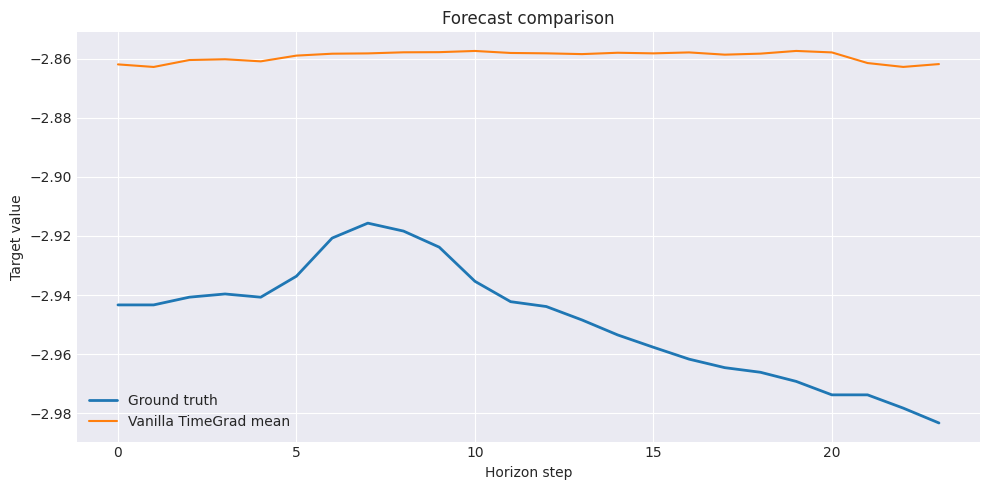

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(truth[:, 0], label='Ground truth', linewidth=2)
plt.plot(vanilla_mean[:, 0], label='Vanilla TimeGrad mean')
#plt.plot(cond_mean[:, 0], label='Conditional TimeGrad mean')
plt.xlabel('Horizon step')
plt.ylabel('Target value')
plt.title('Forecast comparison')
plt.legend()
plt.tight_layout()
plt.show()